# 1 Data Wrangling: *WeRateDogs* Twitter Data

In [459]:
#Importing required libraries
import pandas as pd
import numpy as np
import tweepy
import os
import requests
import re
import json
import datetime
import matplotlib.pyplot as plt
import warnings
from scipy.stats import skew  
from timeit import default_timer as timer
warnings.filterwarnings('ignore')
%matplotlib inline

## 1.1 Gathering Data

### 1.1.1 Twitter Archive Data
This dataset was downloaded directly from Udacity resources.

In [460]:
#Twitter archive data
archive = pd.read_csv('twitter-archive-enhanced.csv')
archive

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None


### 1.1.2 Image Predictions Data
This data is downloaded programatically via `requests` package

In [461]:
#Downloading image predictions
folder_name = 'Image predict'
#making sure the file exists
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
#getting the response
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)
#and finally, downloading
with open(os.path.join(folder_name, url.split('/')[-1]), mode = 'wb') as file:
    file.write(response.content)

In [462]:
#checking if the tsv file was downloaded
os.listdir(folder_name)

['image-predictions.tsv']

In [463]:
#now reading the image prediction data (after copying the tsv file into the working directory)
image_predictions = pd.read_csv('image-predictions.tsv', sep = '\t')
#image_predictions.head()

### 1.1.3 Twitter API Data

#### 1.1.3.1 Creating API object using `tweepy`

In [464]:
#credentials
consumer_key = '**********'
consumer_secret = '*********'
access_token = '*********'
access_secret = '**********'
#creating API object
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

#### 1.1.3.2 Data Query to download `json` file

In [465]:
#Query Twitter's API for JSON data for each tweet ID in the Twitter archive
errors = {}
count = 0
start = timer()
if not os.path.isfile('tweet_json.txt'):
    # create the file and write in it
    with open ('tweet_json.txt', 'w') as file:
        for tweet_id in archive['tweet_id']:
            count += 1
            try:
                status = api.get_status(tweet_id, wait_on_rate_limit=True, sleep_on_rate_limit=False, wait_on_rate_limit_notify=True, tweet_mode = 'extended')
                json.dump(status._json, file)
                file.write('\n')
            except Exception as e:
                print("Error on tweet id {}".format(tweet_id) + ";" + str(e))
                errors[tweet_id] = e
end = timer()
print(end - start)
print(count)

0.000840000000607688
0


#### 1.1.3.3 Creating the API DataFrame
This is the dataframe which contains the favourite count and retweet count

In [466]:
#Reading data from json file and creating a list of dictionaries
#Each dictionary contains a tweet's data
tweets=[]
with open('tweet_json.txt', encoding = 'utf-8') as file:
    for line in file:
        tweet = json.loads(line)
        tweets.append(tweet)
#transforming the tweets into a dataframe
api_df = pd.DataFrame(tweets)

In [467]:
api_df.head()

,created_at,id,id_str,full_text,truncated,display_text_range,entities,extended_entities,source,in_reply_to_status_id,...,favorited,retweeted,possibly_sensitive,possibly_sensitive_appealable,lang,retweeted_status,quoted_status_id,quoted_status_id_str,quoted_status_permalink,quoted_status
0,Tue Aug 01 16:23:56 +0000 2017,892420643555336193,892420643555336193,This is Phineas. He's a mystical boy. Only eve...,False,"[0, 85]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892420639486877696, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,False,False,en,NaN,NaN,NaN,NaN,NaN
1,Tue Aug 01 00:17:27 +0000 2017,892177421306343426,892177421306343426,This is Tilly. She's just checking pup on you....,False,"[0, 138]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892177413194625024, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,False,False,en,NaN,NaN,NaN,NaN,NaN
2,Mon Jul 31 00:18:03 +0000 2017,891815181378084864,891815181378084864,This is Archie. He is a rare Norwegian Pouncin...,False,"[0, 121]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891815175371796480, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,False,False,en,NaN,NaN,NaN,NaN,NaN
3,Sun Jul 30 15:58:51 +0000 2017,891689557279858688,891689557279858688,This is Darla. She commenced a snooze mid meal...,False,"[0, 79]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891689552724799489, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,False,False,en,NaN,NaN,NaN,NaN,NaN
4,Sat Jul 29 16:00:24 +0000 2017,891327558926688256,891327558926688256,This is Franklin. He would like you to stop ca...,False,"[0, 138]","{'hashtags': [{'text': 'BarkWeek', 'indices': ...","{'media': [{'id': 891327551943041024, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,False,False,en,NaN,NaN,NaN,NaN,NaN


In [468]:
api_df.columns

Index(['created_at', 'id', 'id_str', 'full_text', 'truncated',
       'display_text_range', 'entities', 'extended_entities', 'source',
       'in_reply_to_status_id', 'in_reply_to_status_id_str',
       'in_reply_to_user_id', 'in_reply_to_user_id_str',
       'in_reply_to_screen_name', 'user', 'geo', 'coordinates', 'place',
       'contributors', 'is_quote_status', 'retweet_count', 'favorite_count',
       'favorited', 'retweeted', 'possibly_sensitive',
       'possibly_sensitive_appealable', 'lang', 'retweeted_status',
       'quoted_status_id', 'quoted_status_id_str', 'quoted_status_permalink',
       'quoted_status'],
      dtype='object')

In [469]:
#Dropping the columns which we don't need
dropped_cols = ['created_at', 'id', 'full_text', 'truncated',
       'display_text_range', 'entities', 'extended_entities', 'source',
       'in_reply_to_status_id', 'in_reply_to_status_id_str',
       'in_reply_to_user_id', 'in_reply_to_user_id_str',
       'in_reply_to_screen_name', 'user', 'geo', 'coordinates', 'place',
       'contributors', 'is_quote_status',
       'favorited', 'retweeted', 'possibly_sensitive',
       'possibly_sensitive_appealable', 'lang', 'retweeted_status',
       'quoted_status_id', 'quoted_status_id_str', 'quoted_status_permalink',
       'quoted_status']
api_df = api_df.drop(dropped_cols, axis=1)
api_df.head()

,id_str,retweet_count,favorite_count
0,892420643555336193,7511,35530
1,892177421306343426,5575,30752
2,891815181378084864,3692,23116
3,891689557279858688,7695,38820
4,891327558926688256,8295,37099


In [470]:
#Whew! finally, my 3 dataframes
print(archive.shape)
print(image_predictions.shape)
print(api_df.shape)

(2356, 17)
(2075, 12)
(2330, 3)


## 1.2 Data Assessment

### 1.2.1 Visual Assessment
Let's explore and note down some conclusions.<br>
*Note:* Most of the visual assessment I did was using Google sheets and Atom text editor.

#### 1.2.1.1 Archive Data

In [471]:
archive

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None


##### *Conclusions*
- Some names in `name` column aren't capitalized (Consistency Quality issue)
- Some names in `name` column are missing (Completeness Quality issue)
- Gotta check the rating in `rating_numerator` because they might be wrong (Accuracy Quality issue)
- 1 variable in 4 columns (doggo, floofer, pupper, puppo) (Tidiness issue)

##### *To be investigated*
- '+0000' in `timestamp` column, check DT
- Retweets & replies should be eliminated, check `retweeted_status_id` & `in_reply_to_status_id` columns

#### 1.2.1.2 Image Predictions Data

In [472]:
image_predictions

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True


##### *Conclusions*
- Some predictions are capitalized and some of them are not (Consistency Quality issue)
- Predictions are distributed into 3 columns `p1`, `p2`, and `p3` (Tidiness issue)
##### *To be investigated*
- `img_num` column is always 1 except sometimes, what does this column represent?

#### 1.2.1.3 Twitter API Data

In [473]:
api_df

,id_str,retweet_count,favorite_count
0,892420643555336193,7511,35530
1,892177421306343426,5575,30752
2,891815181378084864,3692,23116
3,891689557279858688,7695,38820
4,891327558926688256,8295,37099
...,...,...,...
2325,666049248165822465,40,96
2326,666044226329800704,126,266
2327,666033412701032449,39,110
2328,666029285002620928,41,120


##### *Conclusions*
- This table isn't considered an observational unit (Tidiness issue)

### 1.2.2 Programmatic Assessment
Let's get to the real detective business *gets the magnifying lens

#### 1.2.2.1 Archive Data

In [474]:
archive.shape

(2356, 17)

In [475]:
archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [476]:
archive.rating_numerator.describe()

count    2356.000000
mean       13.126486
std        45.876648
min         0.000000
25%        10.000000
50%        11.000000
75%        12.000000
max      1776.000000
Name: rating_numerator, dtype: float64

In [477]:
archive[archive.rating_numerator >= 17]
#Note: Most of them doesn't have 10 in rating_denominator which means this isn't the rating

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
55,881633300179243008,8.816070e+17,4.738443e+07,2017-07-02 21:58:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@roushfenway These are good dogs but 17/10 is ...,NaN,NaN,NaN,NaN,17,10,None,None,None,None,None
188,855862651834028034,8.558616e+17,1.943518e+08,2017-04-22 19:15:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@dhmontgomery We also gave snoop dogg a 420/10...,NaN,NaN,NaN,NaN,420,10,None,None,None,None,None
189,855860136149123072,8.558585e+17,1.361572e+07,2017-04-22 19:05:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@s8n You tried very hard to portray this good ...,NaN,NaN,NaN,NaN,666,10,None,None,None,None,None
290,838150277551247360,8.381455e+17,2.195506e+07,2017-03-04 22:12:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@markhoppus 182/10,NaN,NaN,NaN,NaN,182,10,None,None,None,None,None
313,835246439529840640,8.352460e+17,2.625958e+07,2017-02-24 21:54:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@jonnysun @Lin_Manuel ok jomny I know you're e...,NaN,NaN,NaN,NaN,960,0,None,None,None,None,None
340,832215909146226688,NaN,NaN,2017-02-16 13:11:49 +0000,"<a href=""http://twitter.com/download/iphone"" r...","RT @dog_rates: This is Logan, the Chow who liv...",7.867091e+17,4.196984e+09,2016-10-13 23:23:56 +0000,https://twitter.com/dog_rates/status/786709082...,75,10,Logan,None,None,None,None
433,820690176645140481,NaN,NaN,2017-01-15 17:52:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",The floofs have been released I repeat the flo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/820690176...,84,70,None,None,None,None,None
516,810984652412424192,NaN,NaN,2016-12-19 23:06:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Sam. She smiles 24/7 &amp; secretly aspir...,NaN,NaN,NaN,"https://www.gofundme.com/sams-smile,https://tw...",24,7,Sam,None,None,None,None
695,786709082849828864,NaN,NaN,2016-10-13 23:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...","This is Logan, the Chow who lived. He solemnly...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/786709082...,75,10,Logan,None,None,None,None
763,778027034220126208,NaN,NaN,2016-09-20 00:24:34 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Sophie. She's a Jubilant Bush Pupper. ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/778027034...,27,10,Sophie,None,None,pupper,None


In [478]:
tweets_need_inspection = archive.text[archive.rating_numerator >=17].tolist()
tweets_need_inspection

['@roushfenway These are good dogs but 17/10 is an emotional impulse rating. More like 13/10s',
 '@dhmontgomery We also gave snoop dogg a 420/10 but I think that predated your research',
 '@s8n You tried very hard to portray this good boy as not so good, but you have ultimately failed. His goodness shines through. 666/10',
 '@markhoppus 182/10',
 "@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho",
 "RT @dog_rates: This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wu…",
 'The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd',
 'Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx',
 "This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wu

*Conclusions:* 
- There are 2 strange high values-namely 1776 & 420-these should be dropped <br>
- '24/7' isn't a rating and that tweet doesn't have a rating so it should also be dropped
- '50/50' isn't a rating, the rating of this tweet is 11/10
- Decimal values-namely 9.75, 11.27, & 11.26- made problems so they should be approximated and added

In [479]:
archive.rating_denominator.describe()

count    2356.000000
mean       10.455433
std         6.745237
min         0.000000
25%        10.000000
50%        10.000000
75%        10.000000
max       170.000000
Name: rating_denominator, dtype: float64

In [480]:
archive.duplicated().sum()

0

In [481]:
archive.name.value_counts()

None         745
a             55
Charlie       12
Lucy          11
Cooper        11
            ... 
Glenn          1
Shikha         1
Billl          1
Jebberson      1
Enchilada      1
Name: name, Length: 957, dtype: int64

In [482]:
archive.timestamp.value_counts()

2017-04-07 16:10:12 +0000    1
2016-11-01 01:00:05 +0000    1
2015-11-16 00:49:46 +0000    1
2016-01-03 20:12:10 +0000    1
2016-07-29 15:27:55 +0000    1
                            ..
2015-11-26 05:28:02 +0000    1
2015-12-15 20:40:47 +0000    1
2017-05-05 18:36:06 +0000    1
2015-11-18 14:18:59 +0000    1
2017-03-22 16:04:20 +0000    1
Name: timestamp, Length: 2356, dtype: int64

In [483]:
tweets_wierd_names = archive.text[archive.name =='a'].to_dict()
tweets_wierd_names

{56: 'Here is a pupper approaching maximum borkdrive. Zooming at never before seen speeds. 14/10 paw-inspiring af \n(IG: puffie_the_chow) https://t.co/ghXBIIeQZF',
 649: 'Here is a perfect example of someone who has their priorities in order. 13/10 for both owner and Forrest https://t.co/LRyMrU7Wfq',
 801: 'Guys this is getting so out of hand. We only rate dogs. This is a Galapagos Speed Panda. Pls only send dogs... 10/10 https://t.co/8lpAGaZRFn',
 1002: 'This is a mighty rare blue-tailed hammer sherk. Human almost lost a limb trying to take these. Be careful guys. 8/10 https://t.co/TGenMeXreW',
 1004: 'Viewer discretion is advised. This is a terrible attack in progress. Not even in water (tragic af). 4/10 bad sherk https://t.co/L3U0j14N5R',
 1017: 'This is a carrot. We only rate dogs. Please only send in dogs. You all really should know this by now ...11/10 https://t.co/9e48aPrBm2',
 1049: 'This is a very rare Great Alaskan Bush Pupper. Hard to stumble upon without spooking. 12/10 wou

##### Quality
- 78 replies (Validity)
- 181 retweets (Validity)
- Missing values in `expanded_urls` column (Completeness)
- Some names in `name` column aren't capitalized (Consistency)
- Some names in `name` column are wrong (Accuracy)
- `rating_numerator` column has illogical values (max value is 1776) (Validity)
- `rating_denominator` column has illogical values (max value is 170) (Validity)
- Erroneous Data Types `tweet_id` & `timestamp` columns (Accuracy)<br>

##### Tidiness
- 1 variable in 4 columns (doggo, floofer, pupper, puppo)
- Date & Time are both stored in the same column `timestamp`

#### 1.2.2.2 Image predictions Data

In [484]:
image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [485]:
image_predictions.duplicated().sum()

0

##### Quality
- Some predictions are capitalized and some of them are not (Consistency)
- Erroneous Data Type `tweet_id` column (Accuracy)<br>

##### Tidiness
- Predictions are distributed into 3 columns `p1`, `p2`, and `p3` 

#### 1.2.2.3 Twitter API Data

In [486]:
api_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2330 entries, 0 to 2329
Data columns (total 3 columns):
id_str            2330 non-null object
retweet_count     2330 non-null int64
favorite_count    2330 non-null int64
dtypes: int64(2), object(1)
memory usage: 54.7+ KB


In [487]:
api_df.describe()

,retweet_count,favorite_count
count,2330.000000,2330.000000
mean,2641.602575,7422.615451
std,4470.070002,11531.785967
min,1.000000,0.000000
25%,536.000000,1290.000000
50%,1234.500000,3225.000000
75%,3058.250000,9077.000000
max,75944.000000,153287.000000


##### Tidiness
- This table isn't an observational unit

## 1.3 Data Assessment Summary

### 1.3.1 Quality issues
####  `archive` table
    - 78 replies (Validity)
    - 181 retweets (Validity)
    - Null values in `expanded_urls` column (Validity)
    - Some names in `name` column aren't capitalized (Consistency)
    - Some names in `name` column are wrong (Accuracy)
    - `rating_numerator` column has illogical values (max value is 1776) (Validity)
    - `rating_denominator` column has illogical values (max value is 170) (Validity)
    - Erroneous Data Types `tweet_id` & `timestamp` columns (Accuracy)
    
####  `image_predictions` table
    - Some predictions are capitalized and some of them are not (Consistency)
    - Erroneous Data Type `tweet_id` column (Accuracy)


### 1.3.2 Tidiness issues

#### `archive` table
    - Date & Time are both stored in the same column `timestamp`
    
####  `image_predictions` table
    - Predictions are distributed into 3 columns `p1`, `p2`, and `p3` 
    
####  `api` table
    - This table isn't an observational unit

## 1.4 Data Cleaning

In [488]:
#Creating copies of all the dataframes
archive_clean = archive.copy()
img_predict_clean = image_predictions.copy()
api_df_clean = api_df.copy()

### 1.4.1 Fixing Data Quality Issues

#### 1.4.1.1 Capitalization Issues (Consistency)
- `name` column in `archive` table
- `p1`, `p2`, & `p3` columns in `img_predict_clean` table <br>

##### 1.4.1.1.1 Define
Capitalize values of the mentioned columns using `str.title()` function <br>

##### 1.4.1.1.2 Code

In [489]:
archive_clean.name = archive_clean.name.str.title()
img_predict_clean.p1 = img_predict_clean.p1.str.title()
img_predict_clean.p2 = img_predict_clean.p2.str.title()
img_predict_clean.p3 = img_predict_clean.p3.str.title()

##### 1.4.1.1.3 Test

In [490]:
archive_clean.name.value_counts

<bound method IndexOpsMixin.value_counts of 0        Phineas
1          Tilly
2         Archie
3          Darla
4       Franklin
          ...   
2351        None
2352           A
2353           A
2354           A
2355        None
Name: name, Length: 2356, dtype: object>

In [491]:
img_predict_clean.head(20)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_Springer_Spaniel,0.465074,True,Collie,0.156665,True,Shetland_Sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,Redbone,0.506826,True,Miniature_Pinscher,0.074192,True,Rhodesian_Ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_Shepherd,0.596461,True,Malinois,0.138584,True,Bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_Ridgeback,0.408143,True,Redbone,0.360687,True,Miniature_Pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,Miniature_Pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_Mountain_Dog,0.651137,True,English_Springer,0.263788,True,Greater_Swiss_Mountain_Dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,Box_Turtle,0.933012,False,Mud_Turtle,0.045885,False,Terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,Chow,0.692517,True,Tibetan_Mastiff,0.058279,True,Fur_Coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,Shopping_Cart,0.962465,False,Shopping_Basket,0.014594,False,Golden_Retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,Miniature_Poodle,0.201493,True,Komondor,0.192305,True,Soft-Coated_Wheaten_Terrier,0.082086,True


#### 1.4.1.2 Retweets, Replies, & Tweets with no Images (Validity)
- In `archive` table, there are 78 replies.
- In `archive` table, there are 181 retweets.
- In `archive` table, there are tweets with no `expanded urls` value <br>

##### 1.4.1.2.1 Define
Remove these rows using the `drop` function.

##### 1.4.1.2.2 Code

In [492]:
#Removing replies from img_predict_clean
img_predict_clean = img_predict_clean[archive_clean.in_reply_to_status_id.isnull()]
#Removing retweets from img_predict_clean
img_predict_clean = img_predict_clean[archive_clean.retweeted_status_id.isnull()]
#Removing tweets with no images from img_predict_clean
img_predict_clean = img_predict_clean[archive_clean.expanded_urls.notnull()]

In [493]:
#Removing replies from api_df_clean
api_df_clean = api_df_clean[archive_clean.in_reply_to_status_id.isnull()]
#Removing retweets from api_df_clean
api_df_clean = api_df_clean[archive_clean.retweeted_status_id.isnull()]
#Removing tweets with no images from api_df_clean
api_df_clean = api_df_clean[archive_clean.expanded_urls.notnull()]

In [494]:
#Removing replies from archive_clean
archive_clean = archive_clean[archive_clean.in_reply_to_status_id.isnull()]
#Removing retweets from archive_clean
archive_clean = archive_clean[archive_clean.retweeted_status_id.isnull()]
#Removing tweets with no images from archive_clean
archive_clean = archive_clean[archive_clean.expanded_urls.notnull()]

##### 1.4.1.2.3 Test

In [495]:
img_predict_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1819 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    1819 non-null int64
jpg_url     1819 non-null object
img_num     1819 non-null int64
p1          1819 non-null object
p1_conf     1819 non-null float64
p1_dog      1819 non-null bool
p2          1819 non-null object
p2_conf     1819 non-null float64
p2_dog      1819 non-null bool
p3          1819 non-null object
p3_conf     1819 non-null float64
p3_dog      1819 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 147.4+ KB


In [496]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2094 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2094 non-null int64
in_reply_to_status_id         0 non-null float64
in_reply_to_user_id           0 non-null float64
timestamp                     2094 non-null object
source                        2094 non-null object
text                          2094 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2094 non-null object
rating_numerator              2094 non-null int64
rating_denominator            2094 non-null int64
name                          2094 non-null object
doggo                         2094 non-null object
floofer                       2094 non-null object
pupper                        2094 non-null object
puppo                         2094 non-null object
dtypes: float64(4), int64(3), object(10)

In [497]:
api_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2068 entries, 0 to 2329
Data columns (total 3 columns):
id_str            2068 non-null object
retweet_count     2068 non-null int64
favorite_count    2068 non-null int64
dtypes: int64(2), object(1)
memory usage: 64.6+ KB


#### 1.4.1.3 `rating_numerator` column values (Validity)
- In `archive` table, `rating_numerator` column has illogical values (max value is 1776)

##### 1.4.1.3.1 Define
These values will be investigated and corrected, programmatically & manually, the invalid ones will be deleted

##### 1.4.1.3.2 Code

In [498]:
#Removing strangely high values
archive_clean = archive_clean[(archive_clean.rating_numerator != 420) & (archive_clean.rating_numerator != 1776)]

In [499]:
#Dropping tweet with 24/7 as rating
idx = archive_clean.index[(archive_clean.rating_numerator == 24) & (archive_clean.rating_denominator == 7)]
archive_clean = archive_clean.drop(index = idx)

In [500]:
#50/50 tweet's rating is actually 11/10
#Changing denominator...
mask = ((archive_clean.rating_denominator == 50) & (archive_clean.rating_numerator == 50))
archive_clean.loc[mask, 'rating_denominator'] = 10

In [501]:
#Changing numerator...
archive_clean.loc[mask, 'rating_numerator'] = 11

In [502]:
#Approximating values with decimals
#First the 75/10 should be 10/10
archive_clean.rating_numerator = archive_clean.rating_numerator.replace(75,10)

In [503]:
#Second the 27/10 should be 10/10
archive_clean.rating_numerator = archive_clean.rating_numerator.replace(27,11)

In [504]:
#Third the 26/10 should be 10/10
archive_clean.rating_numerator = archive_clean.rating_numerator.replace(26,11)

##### 1.4.1.3.3 Test

In [505]:
archive_clean[archive_clean.rating_numerator >= 17]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
433,820690176645140481,NaN,NaN,2017-01-15 17:52:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",The floofs have been released I repeat the flo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/820690176...,84,70,None,None,None,None,None
902,758467244762497024,NaN,NaN,2016-07-28 01:00:57 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Why does this never happen at my front door......,NaN,NaN,NaN,https://twitter.com/dog_rates/status/758467244...,165,150,None,None,None,None,None
1120,731156023742988288,NaN,NaN,2016-05-13 16:15:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to this unbelievably well behaved sq...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/731156023...,204,170,This,None,None,None,None
1228,713900603437621249,NaN,NaN,2016-03-27 01:29:02 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Happy Saturday here's 9 puppers on a bench. 99...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/713900603...,99,90,None,None,None,None,None
1254,710658690886586372,NaN,NaN,2016-03-18 02:46:49 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here's a brigade of puppers. All look very pre...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/710658690...,80,80,None,None,None,None,None
1274,709198395643068416,NaN,NaN,2016-03-14 02:04:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...","From left to right:\nCletus, Jerome, Alejandro...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/709198395...,45,50,None,None,None,None,None
1351,704054845121142784,NaN,NaN,2016-02-28 21:25:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a whole flock of puppers. 60/50 I'll ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/704054845...,60,50,A,None,None,None,None
1433,697463031882764288,NaN,NaN,2016-02-10 16:51:59 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Happy Wednesday here's a bucket of pups. 44/40...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/697463031...,44,40,None,None,None,None,None
1635,684222868335505415,NaN,NaN,2016-01-05 04:00:18 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Someone help the girl is being mugged. Several...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/684222868...,121,110,None,None,None,None,None
1779,677716515794329600,NaN,NaN,2015-12-18 05:06:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",IT'S PUPPERGEDDON. Total of 144/120 ...I think...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/677716515...,144,120,None,None,None,None,None


#### 1.4.1.4 Erroneous Data Types (Accuracy)
- In `archive` table, `tweet_id` column is int
- In `archive` table, `timestamp` column is string
- In `img_predict` table, `tweet_id` column is int

##### 1.4.1.4.1 Define
For the `tweet_id` column, we change them to string using `astype()` function<br>
For the `timestamp` column we change it to datetime object using `to_datetime` function

##### 1.4.1.4.2 Code

In [506]:
#First, the timestamp column
archive_clean.timestamp = pd.to_datetime(archive_clean.timestamp)
#Then, the tweet_id column
#In archive table...
archive_clean.tweet_id = archive_clean.tweet_id.astype(str)
img_predict_clean.tweet_id = img_predict_clean.tweet_id.astype(str)

##### 1.4.1.4.3 Test

In [507]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2091 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2091 non-null object
in_reply_to_status_id         0 non-null float64
in_reply_to_user_id           0 non-null float64
timestamp                     2091 non-null datetime64[ns, UTC]
source                        2091 non-null object
text                          2091 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2091 non-null object
rating_numerator              2091 non-null int64
rating_denominator            2091 non-null int64
name                          2091 non-null object
doggo                         2091 non-null object
floofer                       2091 non-null object
pupper                        2091 non-null object
puppo                         2091 non-null object
dtypes: datetime64[ns, UTC

In [508]:
img_predict_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1819 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    1819 non-null object
jpg_url     1819 non-null object
img_num     1819 non-null int64
p1          1819 non-null object
p1_conf     1819 non-null float64
p1_dog      1819 non-null bool
p2          1819 non-null object
p2_conf     1819 non-null float64
p2_dog      1819 non-null bool
p3          1819 non-null object
p3_conf     1819 non-null float64
p3_dog      1819 non-null bool
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 147.4+ KB


#### 1.4.1.5 Wrong values in `name` column (Accuracy)
- In `archive` table, there are names like 'a' which are clearly wrong.

##### 1.4.1.5.1 Define
Correct names can be extracted from the tweet’s text if they exist, the names are usually after the word 'named'

##### 1.4.1.5.2 Code

In [509]:
len(archive_clean[archive_clean.name =='A'])

55

In [510]:
tweets = archive_clean.text[archive_clean.name =='A'].to_dict()
for index, tweet in tweets.items():
    my_list = tweet.split()
    if 'named' in my_list:
        idx = my_list.index('named')
        archive_clean.name.loc[index] = my_list[idx+1].strip('.')

##### 1.4.1.5.3 Test

In [511]:
len(archive_clean[archive_clean.name =='A'])

36

### 1.4.2 Fixing Data Tidiness Issues

#### 1.4.2.1 Issues in `archive` Table

##### 1.4.2.1.1 Date & Time are both stored in one column `timestamp`
- The column `timestamp` contains both Date & Time
###### 1.4.2.1.1.1 Define
Split the `timestamp` column into `date` and `time` columns using `split` function
###### 1.4.2.1.1.2 Code

In [512]:
#Splitting Date and Time into two columns
archive_clean['time'], archive_clean['date']= archive_clean['timestamp'].apply(lambda x:x.time()), archive_clean['timestamp'].apply(lambda x:x.date())

###### 1.4.2.1.2.3 Test

In [513]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2091 entries, 0 to 2355
Data columns (total 19 columns):
tweet_id                      2091 non-null object
in_reply_to_status_id         0 non-null float64
in_reply_to_user_id           0 non-null float64
timestamp                     2091 non-null datetime64[ns, UTC]
source                        2091 non-null object
text                          2091 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2091 non-null object
rating_numerator              2091 non-null int64
rating_denominator            2091 non-null int64
name                          2091 non-null object
doggo                         2091 non-null object
floofer                       2091 non-null object
pupper                        2091 non-null object
puppo                         2091 non-null object
time                      

#### 1.4.2.2 Issues in `image_predictions` Table

##### 1.4.2.2.1 One variable, three columns; `p1`, `p2`, `p3` 
- Columns describing the result of the 3 predictions represent only one variable
###### 1.4.2.2.1.1 Define
Merge the columns together using the `melt` function
###### 1.4.2.2.1.2 Code

In [514]:
img_predict_clean.columns

Index(['tweet_id', 'jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2',
       'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog'],
      dtype='object')

In [515]:
img_predict_clean = pd.melt(img_predict_clean, id_vars=['tweet_id', 'jpg_url', 'img_num', 'p1_conf', 'p1_dog', 
                                                        'p2_conf', 'p2_dog', 'p3_conf', 'p3_dog'], 
                            var_name='prediction_no', value_name='prediction')

###### 1.4.2.2.1.3 Test

In [516]:
img_predict_clean.tail()

,tweet_id,jpg_url,img_num,p1_conf,p1_dog,p2_conf,p2_dog,p3_conf,p3_dog,prediction_no,prediction
5452,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,0.555712,True,0.225770,True,0.175219,True,p3,German_Short-Haired_Pointer
5453,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,0.170278,False,0.168086,True,0.040836,False,p3,Spatula
5454,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,0.716012,True,0.078253,True,0.031379,True,p3,Kelpie
5455,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,0.323581,True,0.090647,True,0.068957,True,p3,Papillon
5456,892420643555336193,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,0.097049,False,0.085851,False,0.076110,False,p3,Banana


In [517]:
img_predict_clean.columns

Index(['tweet_id', 'jpg_url', 'img_num', 'p1_conf', 'p1_dog', 'p2_conf',
       'p2_dog', 'p3_conf', 'p3_dog', 'prediction_no', 'prediction'],
      dtype='object')

In [518]:
img_predict_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5457 entries, 0 to 5456
Data columns (total 11 columns):
tweet_id         5457 non-null object
jpg_url          5457 non-null object
img_num          5457 non-null int64
p1_conf          5457 non-null float64
p1_dog           5457 non-null bool
p2_conf          5457 non-null float64
p2_dog           5457 non-null bool
p3_conf          5457 non-null float64
p3_dog           5457 non-null bool
prediction_no    5457 non-null object
prediction       5457 non-null object
dtypes: bool(3), float64(3), int64(1), object(4)
memory usage: 357.2+ KB


#### 1.4.2.3 Issues in `api` Table

##### 1.4.2.3.1 This table doesn't represent an observational unit
###### 1.4.2.3.1.1 Define
The `api` table should be merged into the `archive` table using `merge` function
###### 1.4.2.3.1.2 Code

In [519]:
#First rename 'id' into 'tweet_id' in api table
api_df_clean = api_df_clean.rename(columns ={'id_str':'tweet_id'})

In [520]:
#merging both tables
archive_clean = pd.merge(archive_clean, api_df_clean, on=['tweet_id'], how='left')

###### 1.4.2.3.1.3 Test

In [521]:
archive_clean.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo',
       'time', 'date', 'retweet_count', 'favorite_count'],
      dtype='object')

In [522]:
#And now we merge img_predict_clean as well
archive_clean = pd.merge(archive_clean, img_predict_clean, on=['tweet_id'], how='left')

In [523]:
archive_clean.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo',
       'time', 'date', 'retweet_count', 'favorite_count', 'jpg_url', 'img_num',
       'p1_conf', 'p1_dog', 'p2_conf', 'p2_dog', 'p3_conf', 'p3_dog',
       'prediction_no', 'prediction'],
      dtype='object')

## 1.5 Data Storing

In [524]:
archive_clean.to_csv('twitter_archive_master.csv', index=False)

In [525]:
img_predict_clean.to_csv('image_predictions.csv', index=False)

In [526]:
df = pd.read_csv('twitter_archive_master.csv')

## 1.6 Data Analysis with Visuals

### 1.6.1 Histograms for Confidence of Predictions

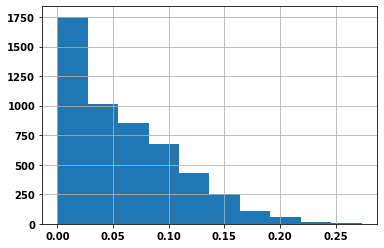

In [527]:
df['p3_conf'].hist();

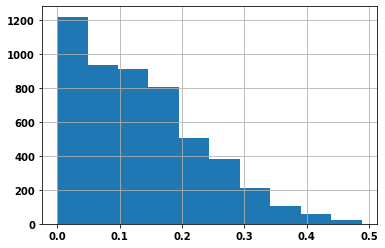

In [528]:
df['p2_conf'].hist();

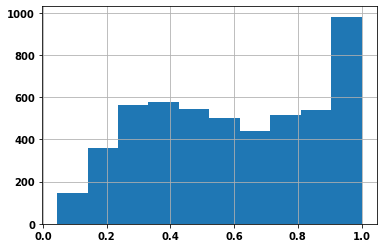

In [529]:
df['p1_conf'].hist();

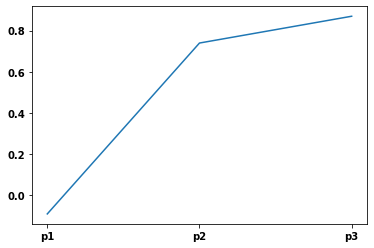

In [530]:
#Graph representing skewness of every prediction confidence
names = ['p1', 'p2', 'p3']
skew_1 = skew(df['p1_conf'], nan_policy='omit')
skew_2 = skew(df['p2_conf'], nan_policy='omit')
skew_3 = skew(df['p3_conf'], nan_policy='omit')
values = [skew_1, skew_2, skew_3]
plt.plot(names, values)
plt.show()

### 1.6.2 Interaction with tweets over time

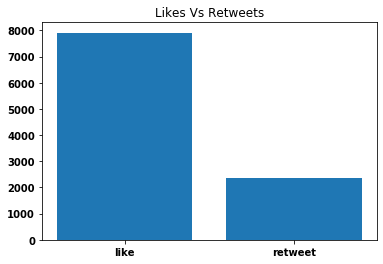

In [531]:
locations = [1, 2]
heights = [df.favorite_count.mean(), df.retweet_count.mean()]
labels = ['like', 'retweet']
plt.bar(locations, heights, tick_label=labels)
plt.title('Likes Vs Retweets');

### 1.6.3 Dog Breeds Plots

In [532]:
#Getting the 10 most common dog breeds
breeds = df.prediction.value_counts().head(10).to_dict()

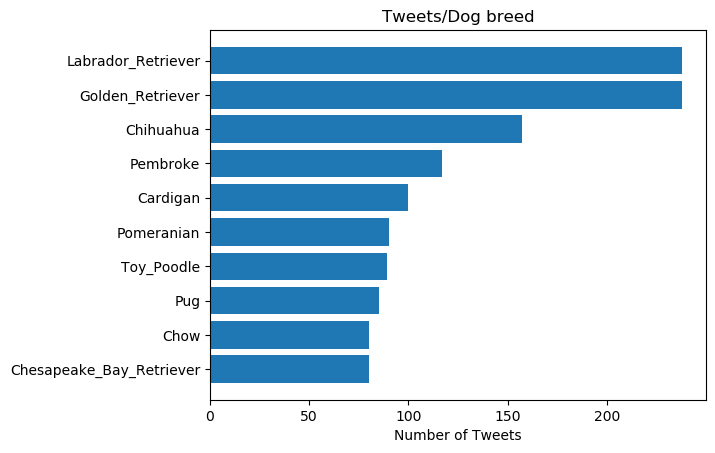

In [533]:
#Creating a bar plot
plt.rcdefaults()
fig, ax = plt.subplots()
#Data to be plotted
breed_value = breeds.keys()
y_pos = np.arange(len(breed_value))
no_of_tweets = breeds.values()
#And now, for the graph...
ax.barh(y_pos, no_of_tweets, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(breed_value)
ax.invert_yaxis() 
ax.set_xlabel('Number of Tweets')
ax.set_title('Tweets/Dog breed')

plt.show()

In [534]:
#Getting the 10 most common dog breeds
breeds_names = df.prediction.value_counts().head(10).to_dict().keys()
retweets = []
likes = []
for breed in breeds_names:
    retweets.append(df[df.prediction == breed].retweet_count.sum())
    likes.append(df[df.prediction == breed].favorite_count.sum())

In [535]:
#Preparing values for xticks plot
ind = np.arange(len(likes))  # the x locations for the groups
width = 0.35       # the width of the bars

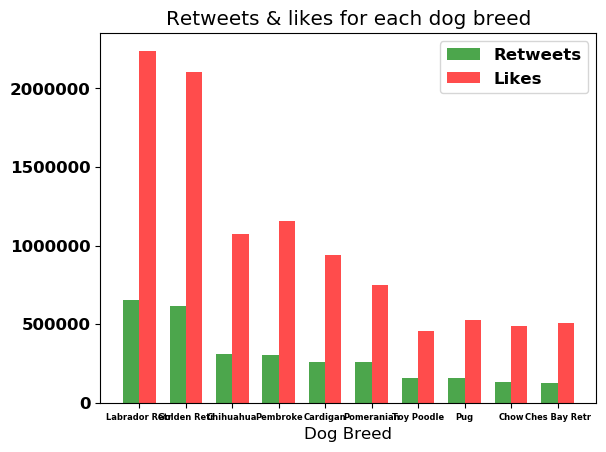

In [545]:
# plot bars
green_bars = plt.bar(ind, retweets, width, color='g', alpha=.7, label='Retweets')
red_bars = plt.bar(ind + width, likes, width, color='r', alpha=.7, label='Likes')

# title and labels
plt.xlabel('Dog Breed')
plt.title('Retweets & likes for each dog breed')
locations = ind + width / 2  # xtick locations
labels =['Labrador Retr', 'Golden Retr', 'Chihuahua', 
         'Pembroke', 'Cardigan', 'Pomeranian', 'Toy Poodle', 'Pug', 'Chow', 'Ches Bay Retr']
plt.xticks(locations, labels, fontsize=6)

# legend
plt.legend();

In [537]:
#Getting Relation between date and number of tweets, retweets, and likes
tweet_count = []
ret_count = []
months = ['2015-12', '2015-11', '2016-12', '2016-11', '2016-10', 
          '2016-09', '2016-08', '2016-07', '2016-06', '2016-05',
          '2016-04', '2016-03', '2016-02', '2016-01', '2017-07', 
          '2017-06', '2017-05', '2017-04', '2017-03', '2017-02', '2017-01']
for i in months:
    tweet_count.append(df[df['date'].str.match(i)].tweet_id.count())
    ret_count.append(df[df['date'].str.match(i)].retweet_count.sum() + df[df['date'].str.match(i)].favorite_count.sum())

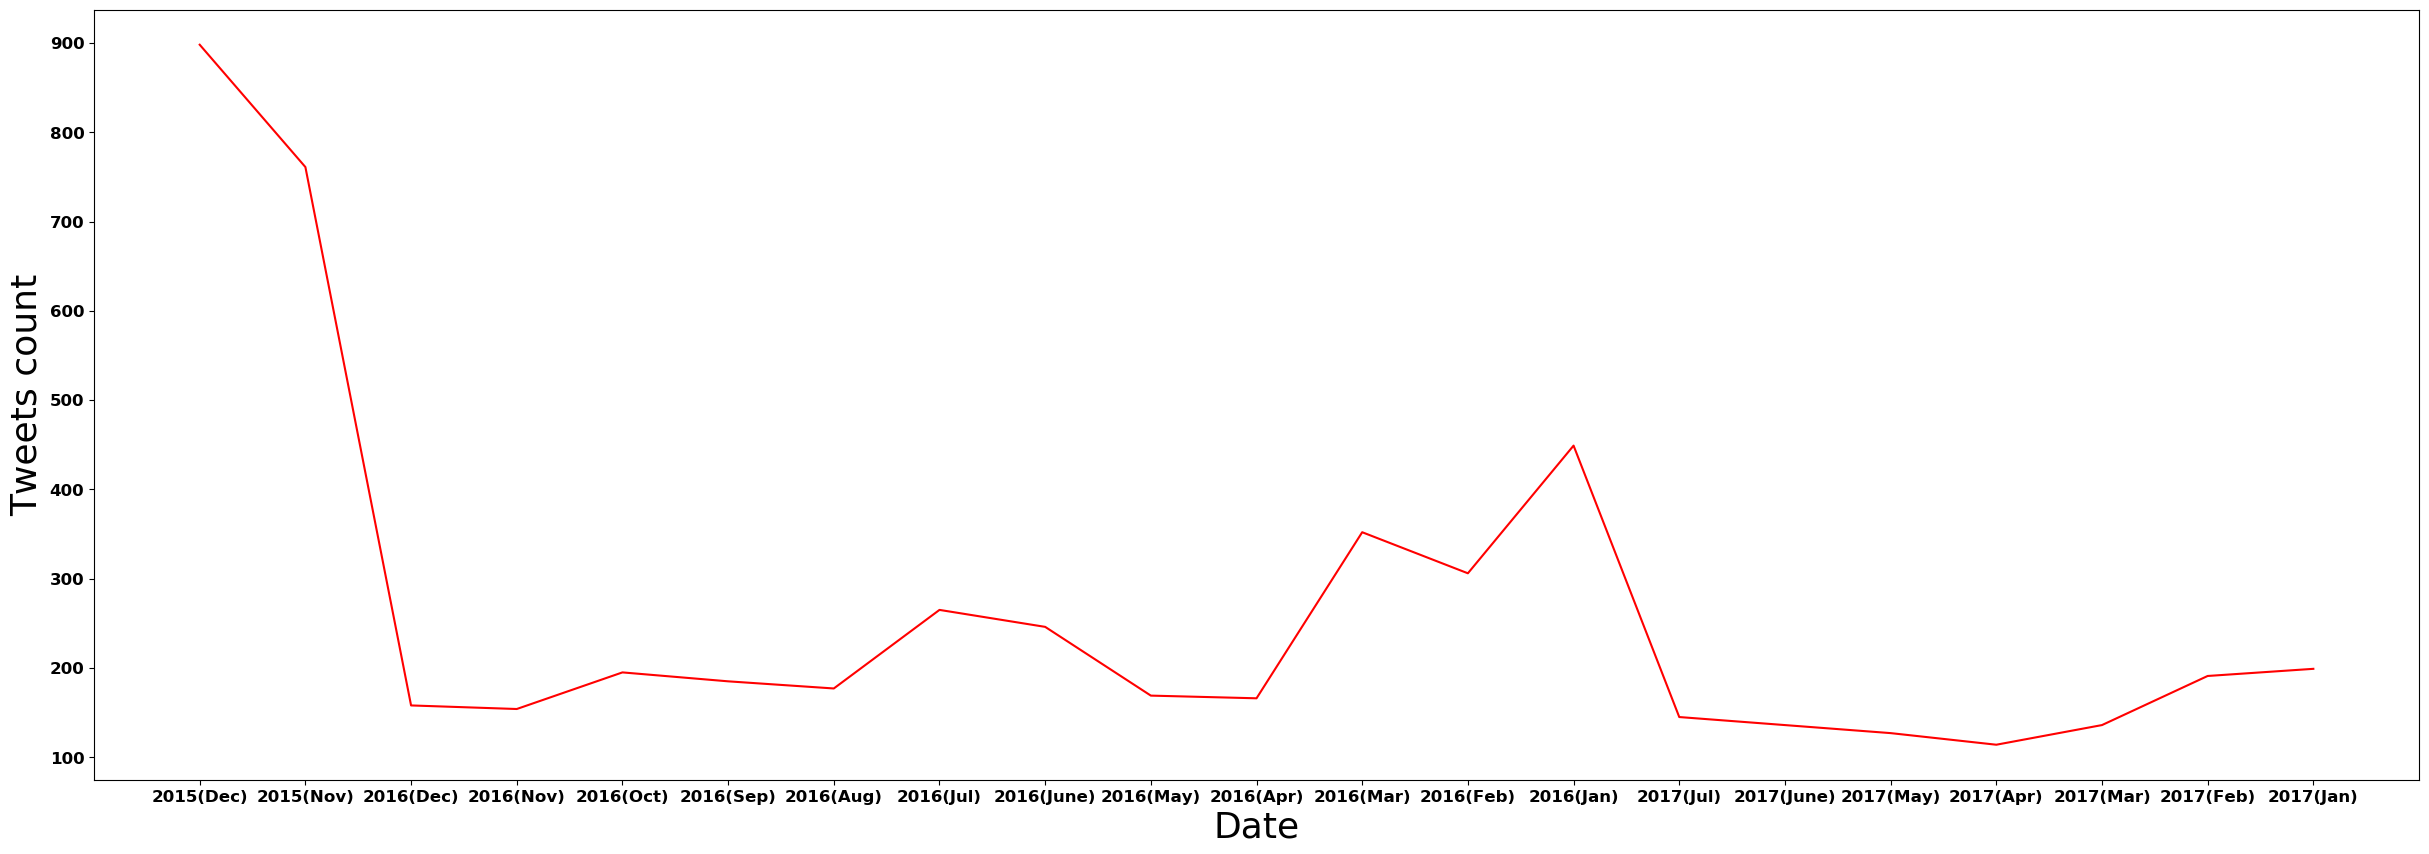

In [538]:
#Months to be displayed...
x_vals =['2015(Dec)', '2015(Nov)', '2016(Dec)', '2016(Nov)', '2016(Oct)', 
         '2016(Sep)', '2016(Aug)', '2016(Jul)', '2016(June)', '2016(May)',
         '2016(Apr)', '2016(Mar)', '2016(Feb)', '2016(Jan)', '2017(Jul)', 
         '2017(June)', '2017(May)', '2017(Apr)', '2017(Mar)', '2017(Feb)', '2017(Jan)']
#Editing font
font = {'weight' : 'bold',
        'size'   : 12}

plt.rc('font', **font)
#plotting...
plt.figure(figsize=(30,10))
plt.plot(x_vals, tweet_count, 'r')
plt.ylabel('Tweets count', fontsize=26)
plt.xlabel('Date', fontsize=26)
plt.show()

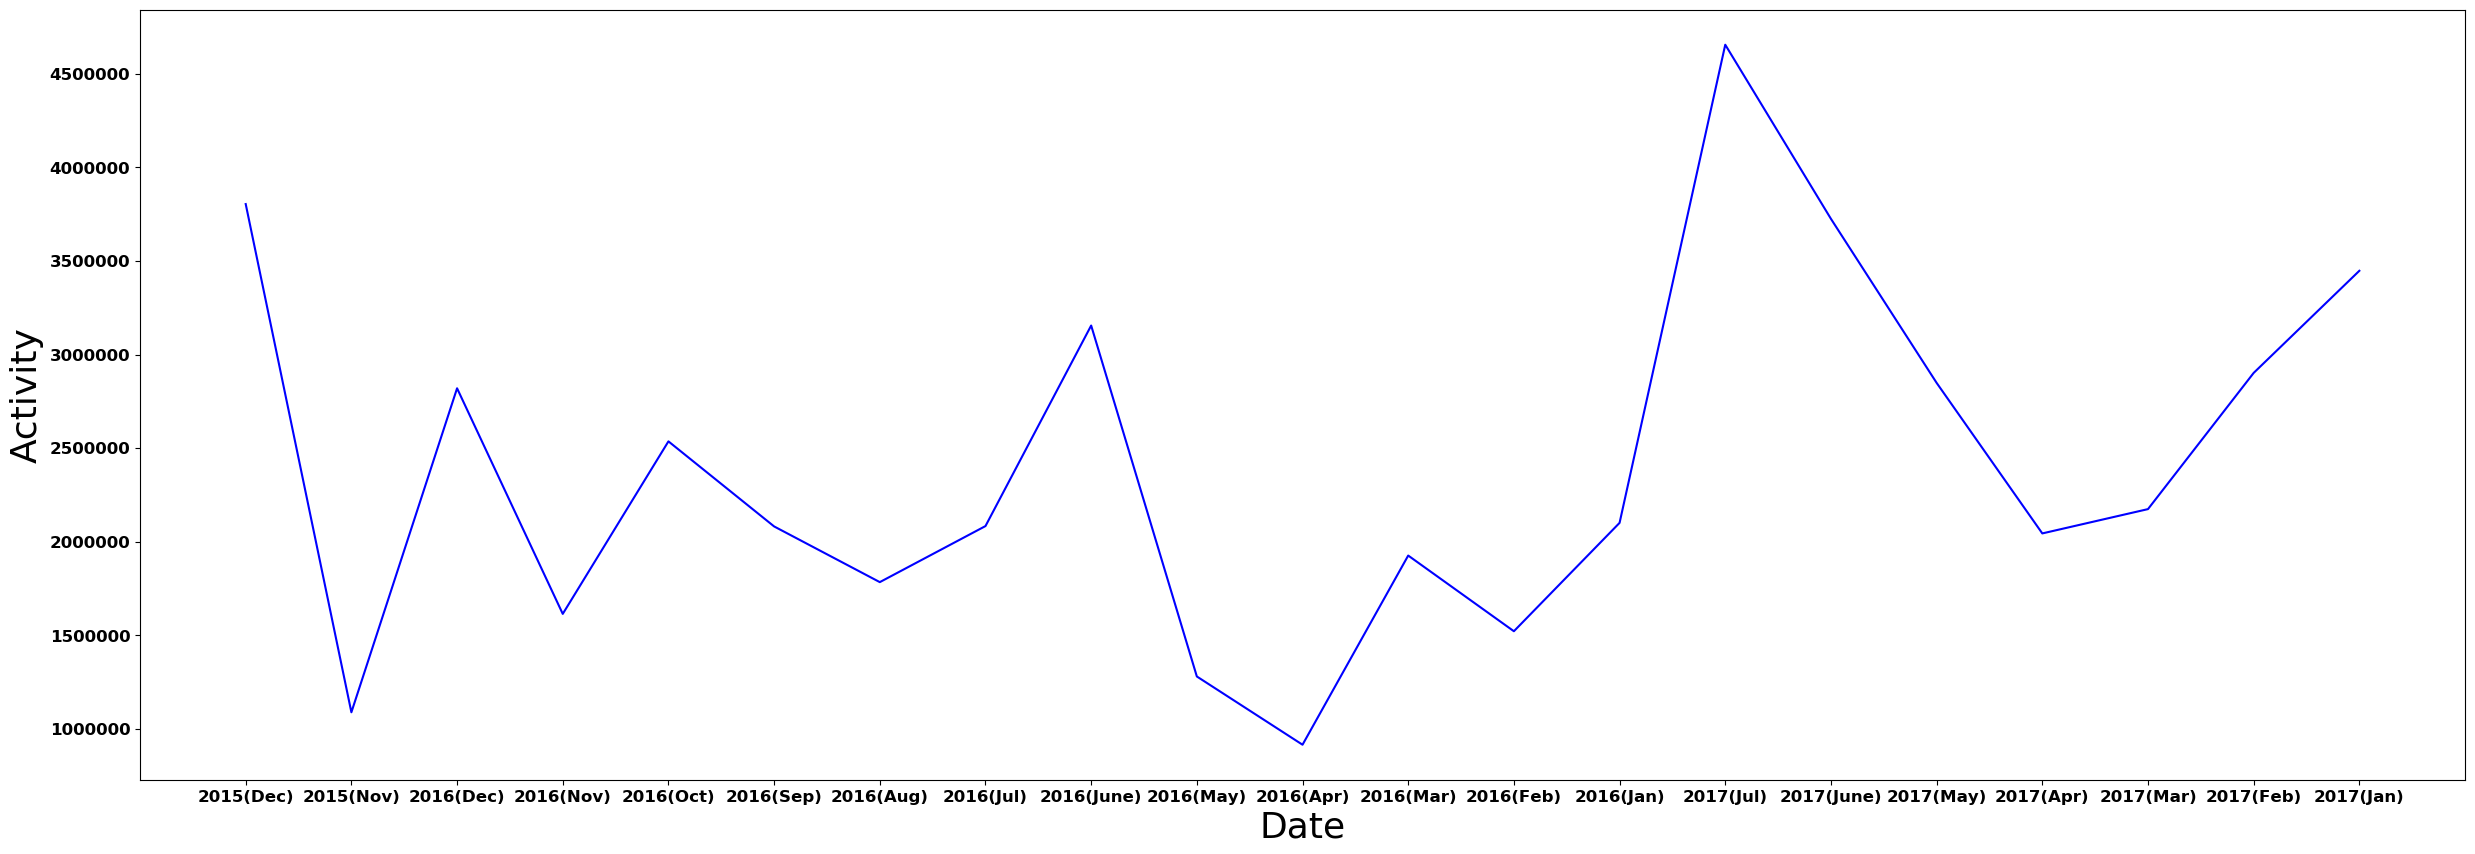

In [539]:
#Editing font
font = {'weight' : 'bold',
        'size'   : 12}

plt.rc('font', **font)
#plotting...
plt.figure(figsize=(30,10))
plt.plot(x_vals, ret_count, 'b')
plt.ylabel('Activity', fontsize=26)
plt.xlabel('Date', fontsize=26)
plt.show()

### 1.6.4 Tweets with dogs Vs Tweets with no dogs

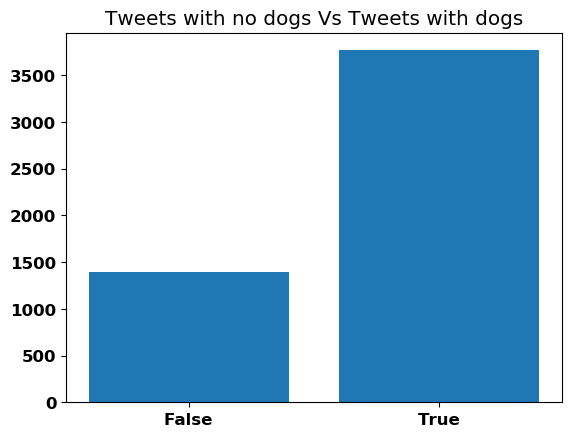

In [546]:
#group the dataframe depending on the strongest prediction p3 & getting the number of tweets
data = df.groupby('p3_dog').count()['tweet_id'].to_dict()
locations = [1, 2]
heights = data.values()
labels = ['False', 'True']
plt.bar(locations, heights, tick_label=labels)
plt.title('Tweets with no dogs Vs Tweets with dogs');

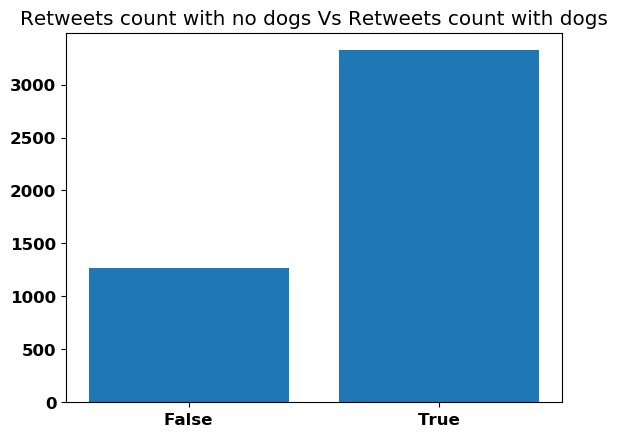

In [547]:
#group the dataframe depending on the strongest prediction p3 & getting the number of retweets
data_ret = df.groupby('p3_dog').count()['retweet_count'].to_dict()
locations = [1, 2]
heights = data_ret.values()
labels = ['False', 'True']
plt.bar(locations, heights, tick_label=labels)
plt.title('Retweets count with no dogs Vs Retweets count with dogs');

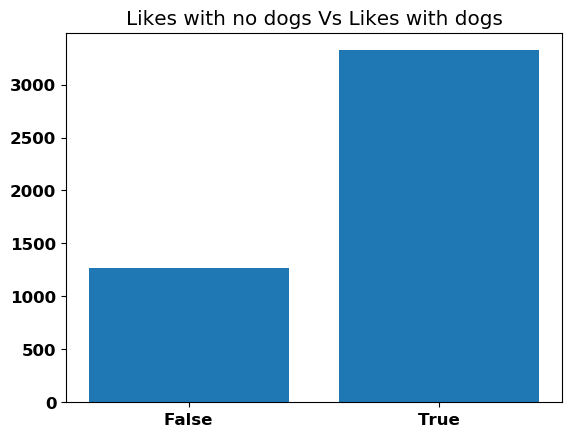

In [548]:
#group the dataframe depending on the strongest prediction p3 & getting the number of likes
data_fav = df.groupby('p3_dog').count()['favorite_count'].to_dict()
locations = [1, 2]
heights = data_fav.values()
labels = ['False', 'True']
plt.bar(locations, heights, tick_label=labels)
plt.title('Likes with no dogs Vs Likes with dogs');